In [2]:
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
from PIL import Image
import yaml
from enum import Enum, unique

class Curvature(Enum):
    NO_CURVATURE = False
    CURVATURE = True

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"
DEVICE

'cuda:1'

/tmp/ipykernel_3200480/1539602785.py:11: DeprecationWarning: FLIP_TOP_BOTTOM is deprecated and will be removed in Pillow 10 (2023-07-01). Use Transpose.FLIP_TOP_BOTTOM instead.
  map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)


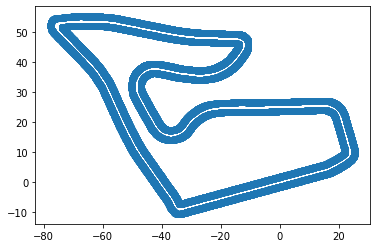

In [11]:
def _get_map_points(map_path, map_ext):
    with open(map_path + '.yaml', 'r') as yaml_stream:
        try:
            map_metadata = yaml.safe_load(yaml_stream)
            map_resolution = map_metadata['resolution']
            origin = map_metadata['origin']
            origin_x = origin[0]
            origin_y = origin[1]
        except yaml.YAMLError as ex:
            print(ex)
    map_img = np.array(Image.open(map_path + map_ext).transpose(Image.FLIP_TOP_BOTTOM)).astype(np.float64)
    map_height = map_img.shape[0]
    map_width = map_img.shape[1]

    # convert map pixels to coordinates
    range_x = np.arange(map_width)
    range_y = np.arange(map_height)
    map_x, map_y = np.meshgrid(range_x, range_y)
    map_x = (map_x * map_resolution + origin_x).flatten()
    map_y = (map_y * map_resolution + origin_y).flatten()
    map_z = np.zeros(map_y.shape)
    map_coords = np.vstack((map_x, map_y, map_z))

    # mask and only leave the obstacle points
    map_mask = map_img == 0.0
    map_mask_flat = map_mask.flatten()
    map_points = map_coords[:, map_mask_flat].T
    return map_points[:,0], map_points[:,1]

map_x, map_y = _get_map_points("../data_generation/track_config/Spielberg_map", ".png")
plt.scatter(map_x, map_y)

In [5]:
train_frame = pd.read_pickle("../../data/train_data.pkl")
test_frame = pd.read_pickle("../../data/test_data.pkl")
full_frame = pd.read_pickle("../../data/final_data.pkl")

In [6]:
no_race_train_frame = train_frame[train_frame['selected_lane'].apply(lambda x: True if x in ['left', 'center', 'right'] else False)]
no_race_test_frame = test_frame[test_frame['selected_lane'].apply(lambda x: True if x in ['left', 'center', 'right'] else False)]
race_test_frame = test_frame[test_frame['selected_lane'].apply(lambda x: True if x in ['race'] else False)]

In [7]:
class TraceRelativeDataset(Dataset):
    def __init__(self, dataframe, curve=False):
        self.dataframe = dataframe
        self.curve = curve

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if self.curve:
            key="input"
        else:
            key="input_no_curve"
        
        try:
            inputs = torch.tensor(np.array(self.dataframe.iloc[idx][key].to_list()), dtype=torch.float32)
            last_pose = torch.tensor(np.array(self.dataframe.iloc[idx]['last_pose'].to_list()), dtype=torch.float32)
            target = torch.tensor(np.array(self.dataframe.iloc[idx]['target'].to_list()), dtype=torch.float32)
        except AttributeError as v:
            inputs = torch.tensor(self.dataframe.iloc[idx][key], dtype=torch.float32)
            last_pose = torch.tensor(self.dataframe.iloc[idx]['last_pose'], dtype=torch.float32)
            target = torch.tensor(self.dataframe.iloc[idx]['target'], dtype=torch.float32)
        return inputs, last_pose, target

train_dataset = TraceRelativeDataset(no_race_train_frame, curve=False)
test_dataset = TraceRelativeDataset(no_race_test_frame, curve=False)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=8)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=8)

In [8]:
def bicycle_model_eval(inputs, last_poses):
    # This version takes in an input of dim 5
    BATCHES = inputs.shape[0]
    states = []  # torch.zeros((81, 4))
    L = 0.3302
    TS = 0.1
    X, Y, THETA, V = 0, 1, 2, 3
    state = torch.zeros((BATCHES, 4,))
    state[:,X] = last_poses[:,0]
    state[:,Y] = last_poses[:,1]
    state[:,THETA] = last_poses[:,2]
    state[:,V] = inputs[:,0]
    states.append(state)
    for i in range(1,81):
        # Advance bicycle model
        state = torch.zeros((BATCHES, 4,))
        state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
        state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
        state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(inputs[:,1])) / L)
        state[:,V] = states[i-1][:,V] + TS*inputs[:,2]
        states.append(state)
    trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
    trace = trace[:,1:,:3]
    return trace

def custom_loss_func(prediction, target):
    loss = F.smooth_l1_loss(prediction[:,:,:2], target[:,:,:2])
    loss += 4*F.smooth_l1_loss(prediction[:,:,2], target[:,:,2])
    #loss += 10*output[0]**2 if output[0]<0 else 0
    #loss += 2*torch.linalg.norm(output)**2
    return loss

def average_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,:,:2]-target[:,:,:2], dim=2)
    ade = torch.mean(loss, dim=0)
    return torch.mean(ade)

def final_displacement_error(prediction, target):
    loss = torch.linalg.norm(prediction[:,-1,:2]-target[:,-1,:2], dim=1)
    return torch.mean(loss)

class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, horizon=60):
        super(LSTMPredictor, self).__init__()
        self.hidden_dim = hidden_dim
        self.horizon = horizon
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)
        
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 3*horizon)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        output = output[:,-1].reshape((inputs.shape[0], self.horizon, 3))
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        return self.forward(inputs)
        

class LSTMPredictorBicycle(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=32, control_outputs=1):
        super(LSTMPredictorBicycle, self).__init__()
        self.hidden_dim = hidden_dim
        self.control_outputs = control_outputs

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=4, batch_first=True)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2output = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.ELU(),
            nn.Linear(hidden_dim//2, hidden_dim//2),
            nn.Linear(hidden_dim//2, 1+control_outputs*2)
        )

    def forward(self, inputs):
        lstm_out, _ = self.lstm(inputs)
        output = self.hidden2output(lstm_out)
        scaled_output = list()
        scaled_output.append(F.softplus(output[:,:,0]))
        for step in range(self.control_outputs):
            scaled_output.append(torch.tanh(output[:,:,(step*2)+1])*np.pi)
            scaled_output.append(output[:,:,(step*2)+2])
        output = torch.dstack(scaled_output)
        return output
    
    def predict(self, inputs, last_poses, horizon=60):
        # Compute LSTM output
        controls = self.forward(inputs)[:, -1]  # Take last prediction
        last_poses = last_poses.to(DEVICE)
        BATCHES = controls.shape[0]
        states = []  # torch.zeros((81, 4))
        L = 0.3302
        TS = 0.1
        X, Y, THETA, V = 0, 1, 2, 3
        CDIMS = 2
        state = torch.zeros((BATCHES, 4,), device=DEVICE)
        state[:,X] = last_poses[:,0]
        state[:,Y] = last_poses[:,1]
        state[:,THETA] = last_poses[:,2]
        state[:,V] = controls[:,0]
        states.append(state)
        step_length = horizon//self.control_outputs
        for i in range(1,horizon+1):
            # Advance bicycle model
            step = min((i-1)//step_length, self.control_outputs-1)
            state = torch.zeros((BATCHES, 4,), device=DEVICE)
            state[:,X] = states[i-1][:,X] + (TS * states[i-1][:,V] * torch.cos(states[i-1][:,THETA]))
            state[:,Y] = states[i-1][:,Y] + (TS * states[i-1][:,V] * torch.sin(states[i-1][:,THETA]))
            state[:,THETA] = states[i-1][:,THETA] + (TS * (states[i-1][:,V] * torch.tan(controls[:,(step*CDIMS)+1])) / L)
            state[:,V] = states[i-1][:,V] + TS*controls[:,(step*CDIMS)+2]
            states.append(state)
        trace = torch.dstack(states).movedim((0,1,2), (0,2,1))
        trace = trace[:,1:,:3]
        return trace

In [25]:
def create_debug_plot(net, train_dataset:TraceRelativeDataset=train_dataset, test_dataset:TraceRelativeDataset=test_dataset, curvature:Curvature=Curvature.NO_CURVATURE, selection:list=[1912, 2465, 533, 905, 277, 1665, 2395, 61, 1054]):
    if selection is None:
        selection = np.random.choice(len(full_frame), 9)
    inputs, last_poses, targets = train_dataset[:len(selection)]
    inputs = torch.zeros_like(inputs, dtype=torch.float32, device=DEVICE)
    last_poses = torch.zeros_like(last_poses, dtype=torch.float32, device=DEVICE)
    for i, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        if curvature is Curvature.NO_CURVATURE:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input_no_curve'], dtype=torch.float32, device=DEVICE)
        else:
            inputs[i] = torch.tensor(dframe.loc[DATA_IDX]['input'], dtype=torch.float32, device=DEVICE)
        last_poses[i] = torch.tensor(dframe.loc[DATA_IDX]['last_pose'], dtype=torch.float32, device=DEVICE)
        targets[i] = torch.tensor(dframe.loc[DATA_IDX]['target'], dtype=torch.float32, device=DEVICE)
    outputs = net.predict(inputs, last_poses).detach().cpu().numpy()

    fig, axs = plt.subplots(3,3,figsize=(10,10), dpi=300)
    for idx, DATA_IDX in enumerate(selection):
        data_in_train = True if DATA_IDX in train_frame.index else False
        if data_in_train:
            dframe = train_frame
        else:
            dframe = test_frame
        linput, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['input'][:,0], dframe.loc[DATA_IDX]['input'][:,1], marker='.', label="Input")
        ltarget, = axs[idx//3, idx%3].plot(dframe.loc[DATA_IDX]['target'][:,0], dframe.loc[DATA_IDX]['target'][:,1], marker='.', label="Target")
        lpred, = axs[idx//3, idx%3].plot(outputs[idx,:,0], outputs[idx,:,1], marker='x', label="Prediction")
        xlim, ylim = np.average(axs[idx//3, idx%3].get_xlim()), np.average(axs[idx//3, idx%3].get_ylim())
        axs[idx//3, idx%3].scatter(map_x, map_y, marker=".", color='black')
        axs[idx//3, idx%3].set(xlim=(xlim-3.5,xlim+3.5),
                               ylim=(ylim-3.5,ylim+3.5),
                               aspect=1.0,
                               adjustable='box',
                               yticklabels=[],
                               xticklabels=[])
        axs[idx//3, idx%3].set_title("{}:{}:{}".format("Train" if data_in_train else "Test",DATA_IDX,dframe.loc[DATA_IDX]['selected_lane']))
    fig.suptitle("Manually Selected Traces")
    fig.legend(handles=[linput, ltarget, lpred])
    return fig, axs

In [26]:
net = LSTMPredictorBicycle()
net.to(DEVICE)

LSTMPredictorBicycle(
  (lstm): LSTM(3, 32, num_layers=4, batch_first=True)
  (hidden2output): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): ELU(alpha=1.0)
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ELU(alpha=1.0)
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): Linear(in_features=16, out_features=3, bias=True)
  )
)

In [33]:
full_frame

,input,input_no_curve,last_pose,steering_range,curvature_range,target,selected_lane
0,"[[-40.162144, 16.563124, 5.689377, -0.21777019...","[[-40.162144, 16.563124, 5.689377], [-40.13379...","[-39.87525008462397, 16.380174182096347, 5.738...",0.056472,0.005443,"[[-39.87525008462397, 16.380174182096347, 5.73...",center
1,"[[-39.87525, 16.380175, 5.7389665, -0.21150316...","[[-39.87525, 16.380175, 5.7389665], [-39.84639...","[-39.58298856019122, 16.21521068862056, 5.7944...",0.056811,0.007024,"[[-39.58298856019122, 16.21521068862056, 5.794...",center
2,"[[-39.58299, 16.21521, 5.79443, -0.20122054, 0...","[[-39.58299, 16.21521, 5.79443], [-39.553596, ...","[-39.28563265825731, 16.069042444697764, 5.862...",0.055633,0.007019,"[[-39.28563265825731, 16.069042444697764, 5.86...",center
3,"[[-39.285633, 16.069042, 5.8620143, -0.1870633...","[[-39.285633, 16.069042, 5.8620143], [-39.2556...","[-38.98277138016194, 15.944002977072085, 5.916...",0.053009,0.005621,"[[-38.98277138016194, 15.944002977072085, 5.91...",center
4,"[[-38.982773, 15.944003, 5.91614, -0.16857345,...","[[-38.982773, 15.944003, 5.91614], [-38.952396...","[-38.676898632169724, 15.837009864617764, 5.97...",0.052631,0.005554,"[[-38.676898632169724, 15.837009864617764, 5.9...",center
...,...,...,...,...,...,...,...
2873,"[[-23.28998, 23.87518, 0.3683079, -0.5744877, ...","[[-23.28998, 23.87518, 0.3683079], [-23.236666...","[-22.754613508311373, 24.075000485490516, 0.34...",0.011189,0.010142,"[[-22.754613508311373, 24.075000485490516, 0.3...",race
2874,"[[-22.754614, 24.075, 0.34060797, -0.44552335,...","[[-22.754614, 24.075, 0.34060797], [-22.700745...","[-22.213757952977566, 24.259969713605873, 0.31...",0.017780,0.011125,"[[-22.213757952977566, 24.259969713605873, 0.3...",race
2875,"[[-22.213758, 24.25997, 0.31289938, -0.3174619...","[[-22.213758, 24.25997, 0.31289938], [-22.1593...","[-21.667511299009128, 24.430025084593698, 0.28...",0.017265,0.010323,"[[-21.667511299009128, 24.430025084593698, 0.2...",race
2876,"[[-21.667511, 24.430025, 0.28516573, -0.384108...","[[-21.667511, 24.430025, 0.28516573], [-21.612...","[-21.115932853475513, 24.58508980968446, 0.268...",0.018359,0.011675,"[[-21.115932853475513, 24.58508980968446, 0.26...",race


(<Figure size 3000x3000 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'Test:2596:race'}>,
         <AxesSubplot:title={'center':'Train:2465:race'}>,
         <AxesSubplot:title={'center':'Train:2715:race'}>],
        [<AxesSubplot:title={'center':'Train:2711:race'}>,
         <AxesSubplot:title={'center':'Train:2246:race'}>,
         <AxesSubplot:title={'center':'Train:2805:race'}>],
        [<AxesSubplot:title={'center':'Test:2329:race'}>,
         <AxesSubplot:title={'center':'Test:2243:race'}>,
         <AxesSubplot:title={'center':'Train:2376:race'}>]], dtype=object))

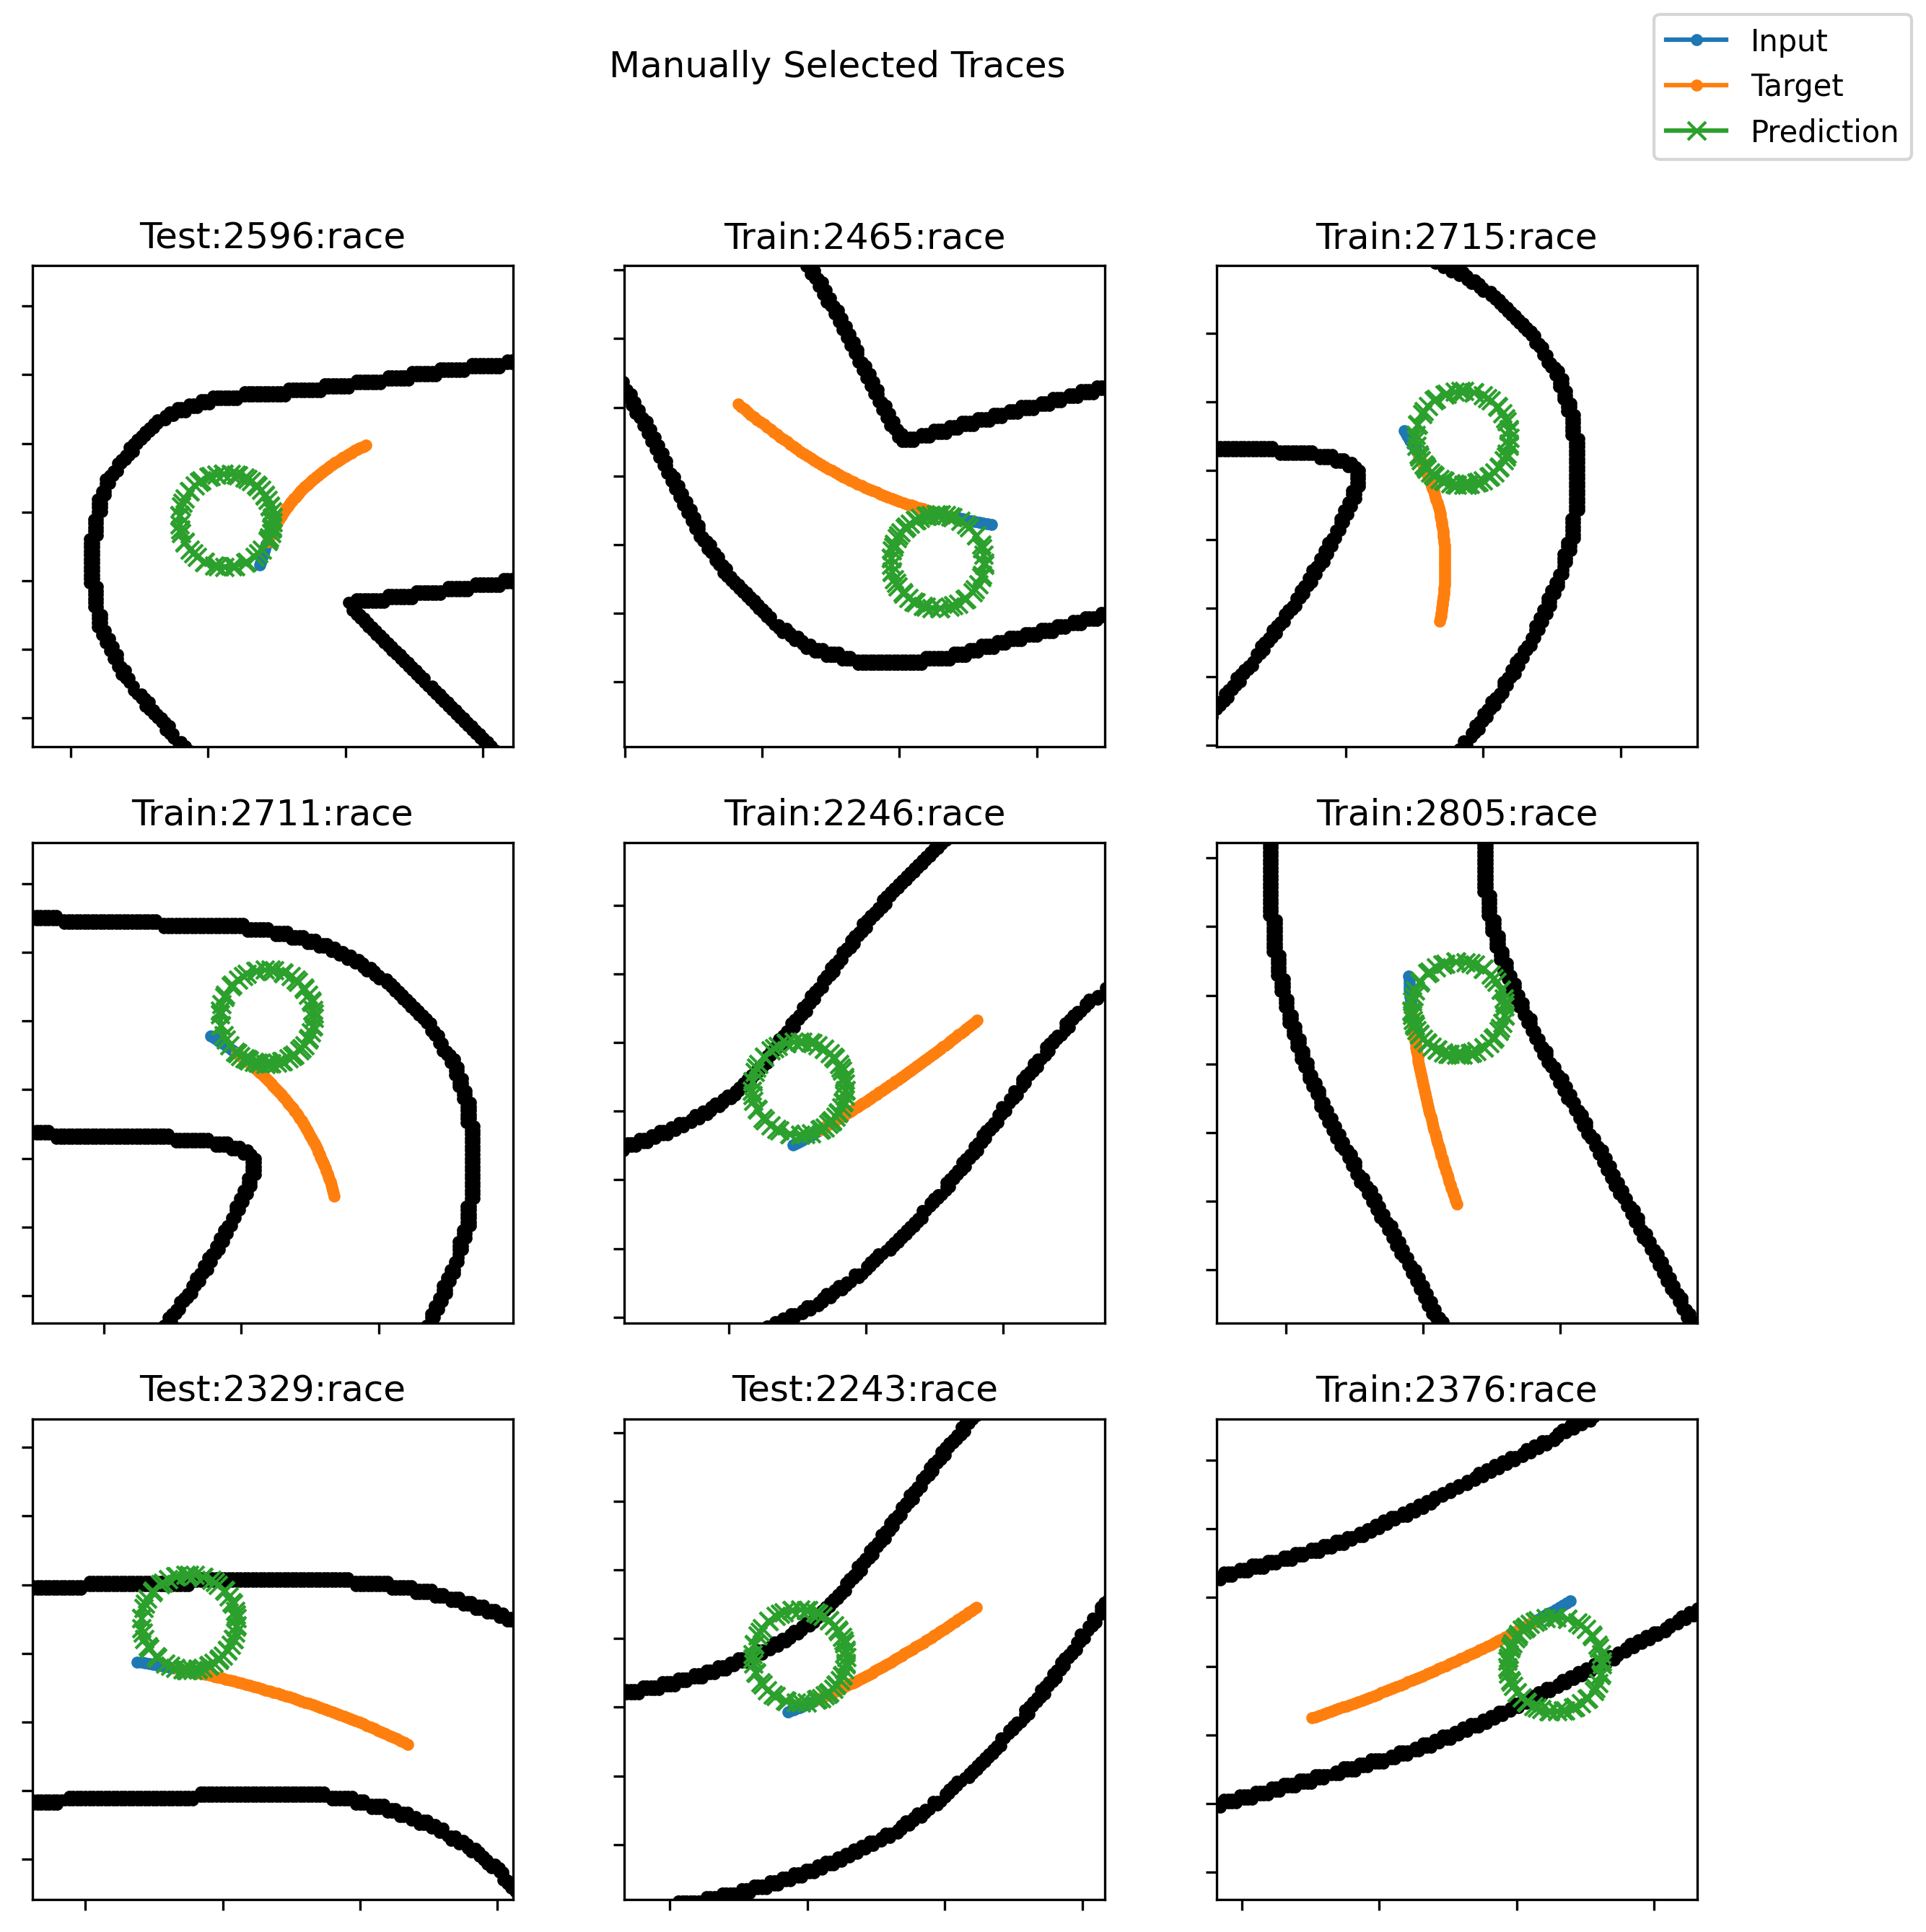

In [46]:
selection = full_frame[full_frame['selected_lane']=='race'].sort_values('curvature_range', ascending=False).index[::10].tolist()[:9]
create_debug_plot(net, selection=selection)

(<Figure size 3000x3000 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'Train:2597:race'}>,
         <AxesSubplot:title={'center':'Train:2718:race'}>,
         <AxesSubplot:title={'center':'Train:2239:race'}>],
        [<AxesSubplot:title={'center':'Train:2796:race'}>,
         <AxesSubplot:title={'center':'Train:2795:race'}>,
         <AxesSubplot:title={'center':'Test:2605:race'}>],
        [<AxesSubplot:title={'center':'Test:2724:race'}>,
         <AxesSubplot:title={'center':'Train:2466:race'}>,
         <AxesSubplot:title={'center':'Train:2365:race'}>]], dtype=object))

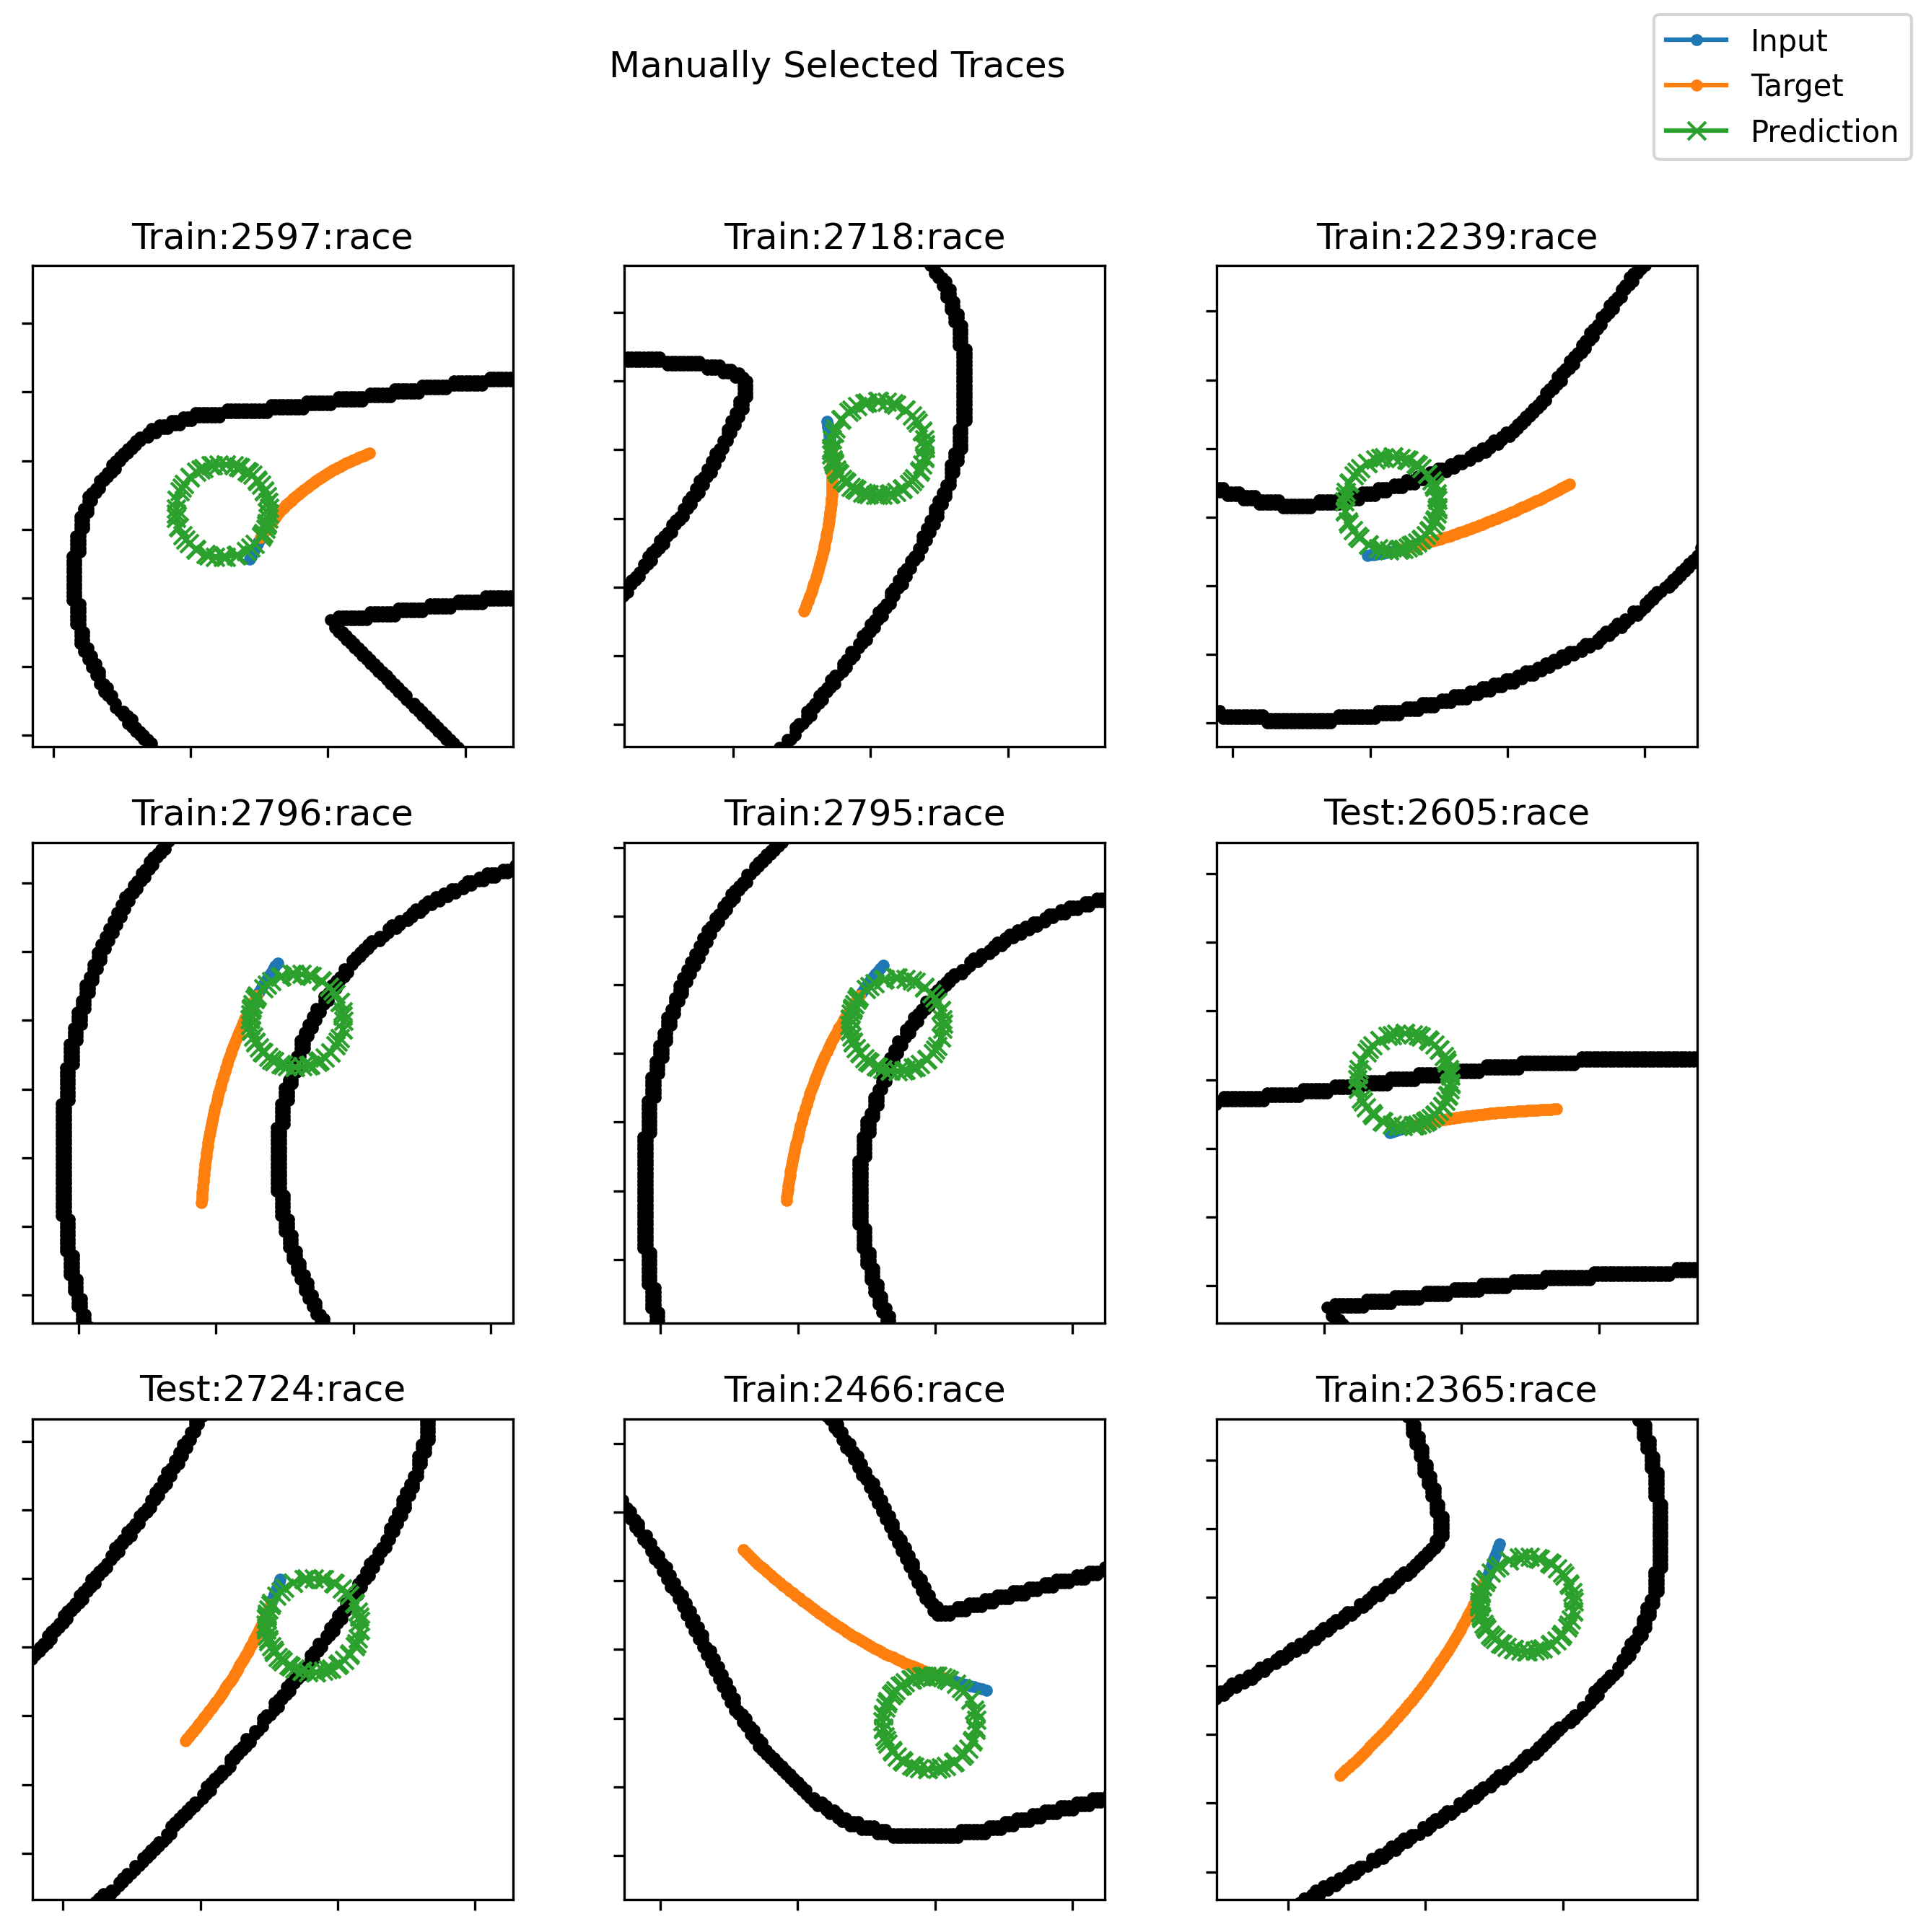

In [47]:
selection = full_frame[full_frame['selected_lane']=='race'].sort_values('steering_range', ascending=False).index[::10].tolist()[:9]
create_debug_plot(net, selection=selection)

(<Figure size 3000x3000 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'Test:2257:race'}>,
         <AxesSubplot:title={'center':'Train:2266:race'}>,
         <AxesSubplot:title={'center':'Train:2683:race'}>],
        [<AxesSubplot:title={'center':'Train:2520:race'}>,
         <AxesSubplot:title={'center':'Train:2304:race'}>,
         <AxesSubplot:title={'center':'Train:2445:race'}>],
        [<AxesSubplot:title={'center':'Train:2420:race'}>,
         <AxesSubplot:title={'center':'Test:2554:race'}>,
         <AxesSubplot:title={'center':'Train:2556:race'}>]], dtype=object))

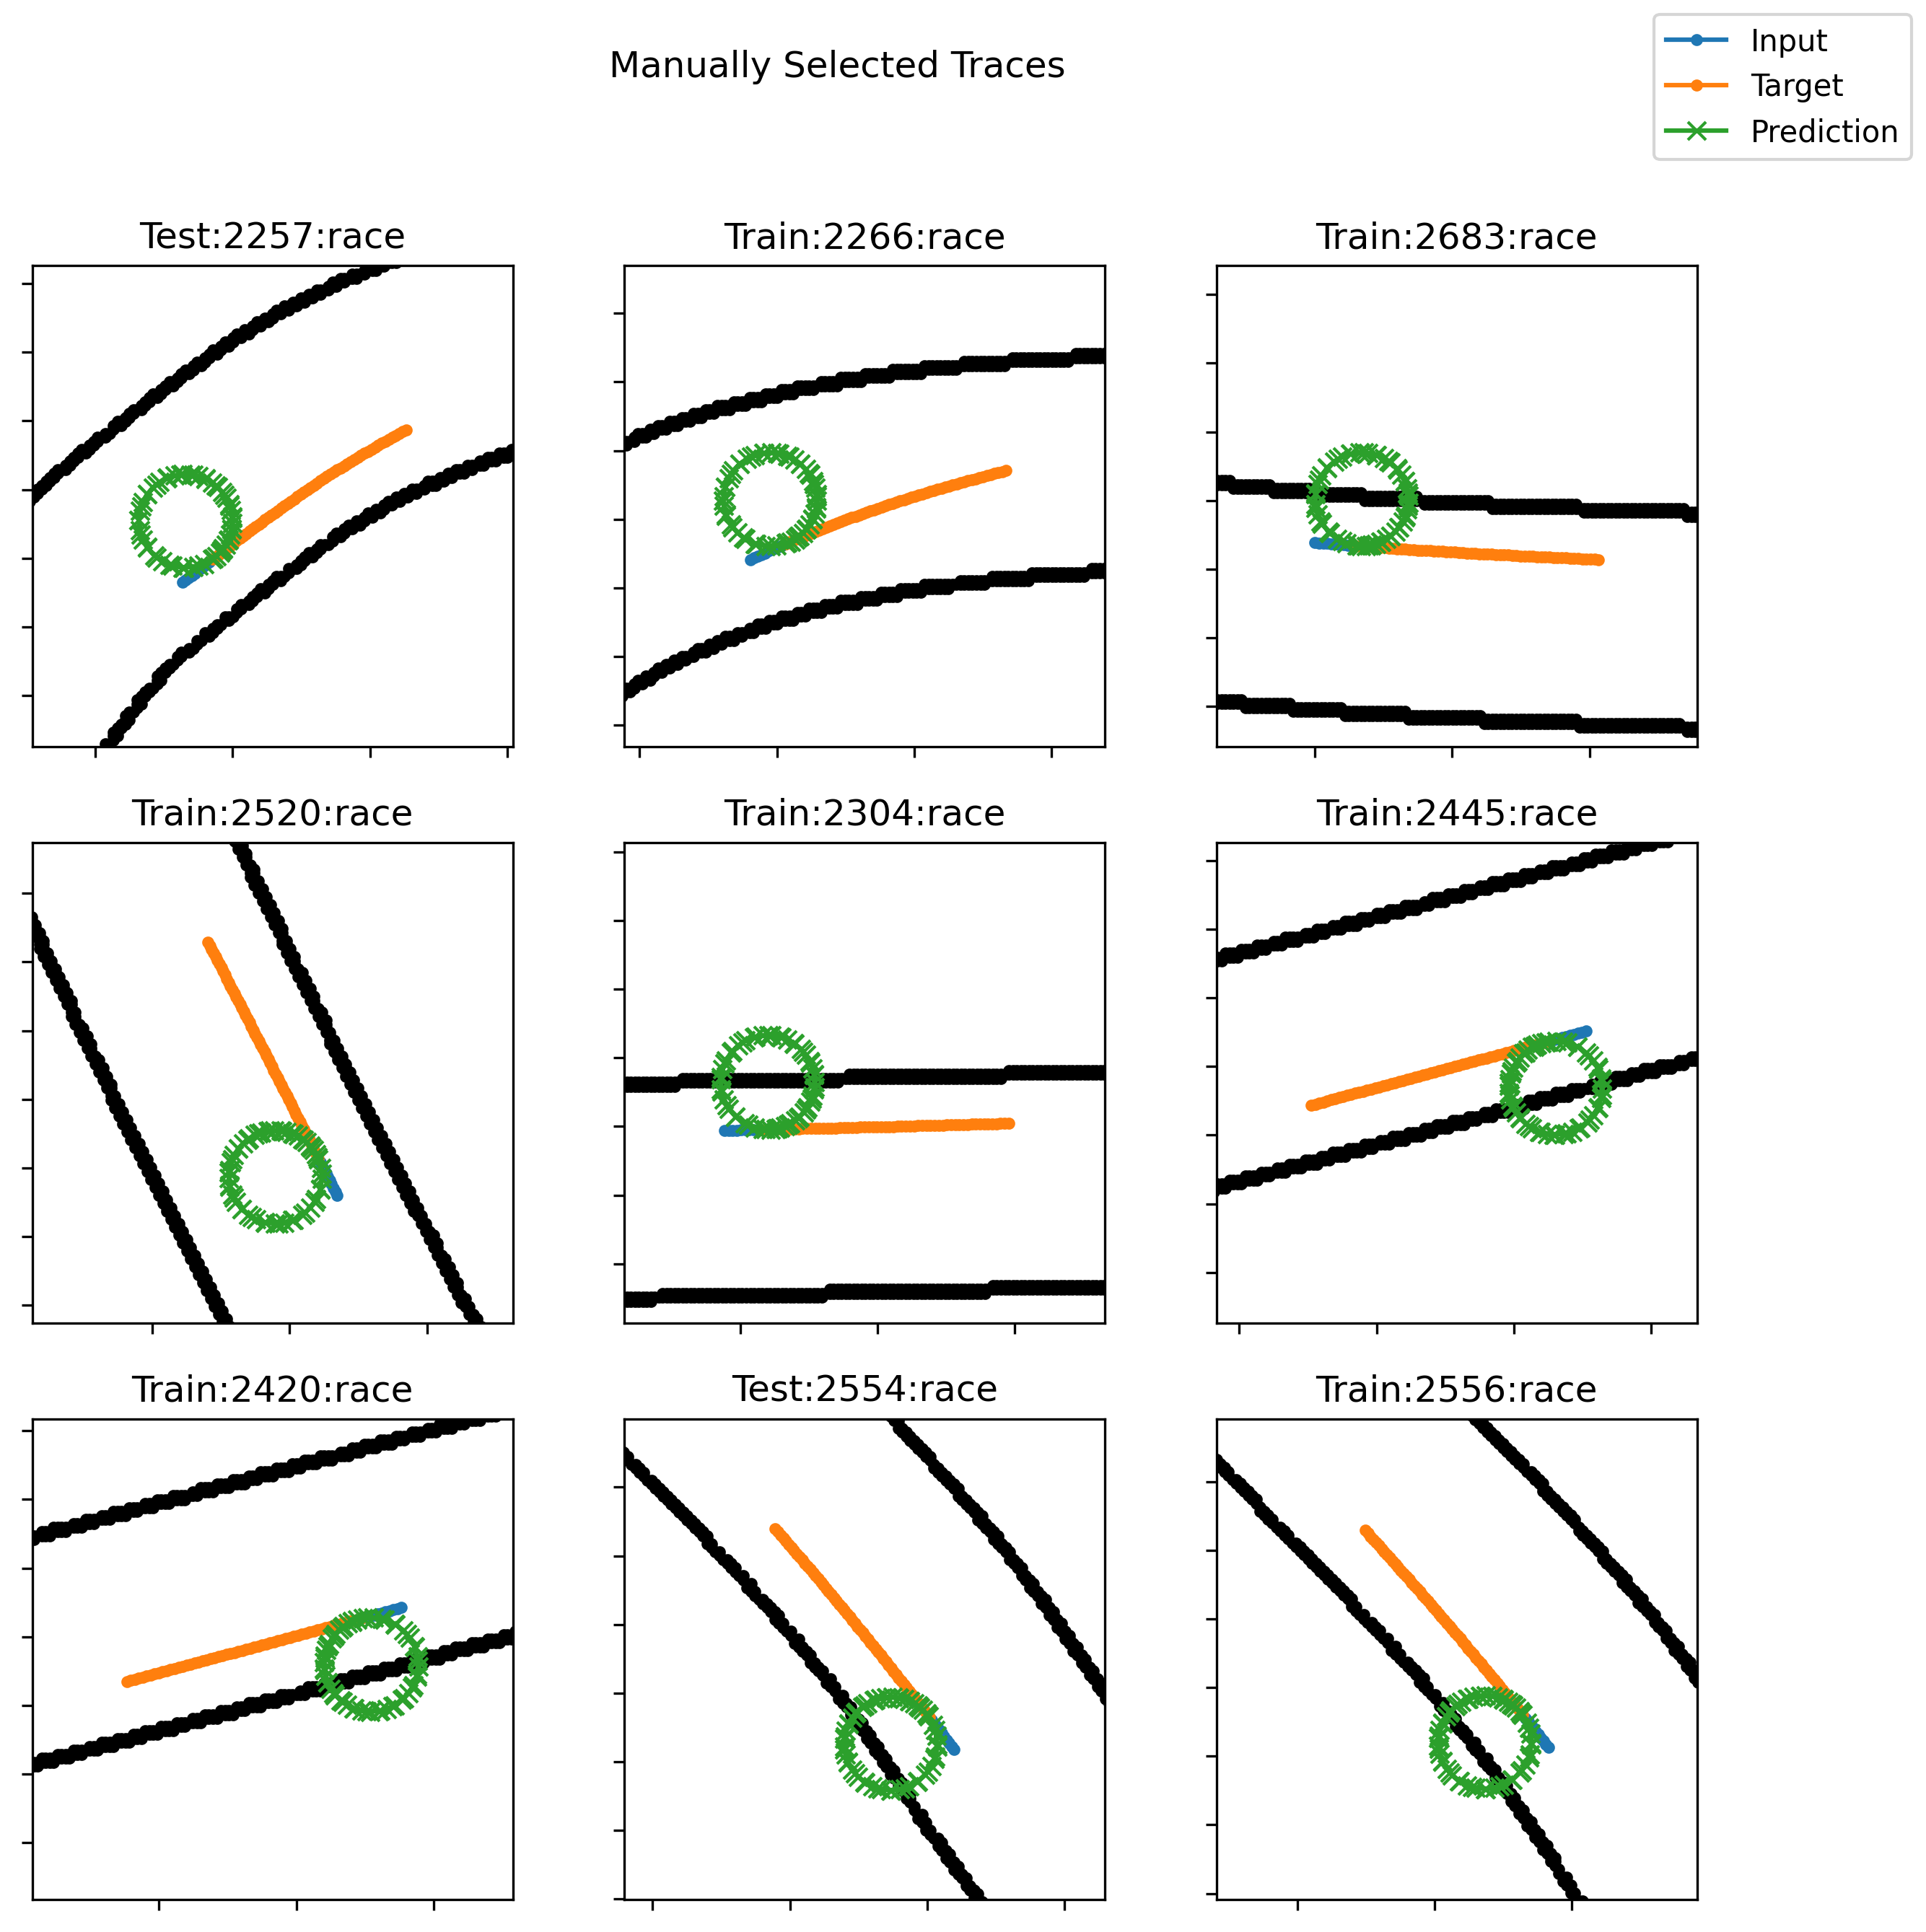

In [48]:
selection = full_frame[full_frame['selected_lane']=='race'].sort_values('steering_range', ascending=False).index[::-10].tolist()[:9]
create_debug_plot(net, selection=selection)

(<Figure size 3000x3000 with 9 Axes>,
 array([[<AxesSubplot:title={'center':'Train:2246:race'}>,
         <AxesSubplot:title={'center':'Test:2329:race'}>,
         <AxesSubplot:title={'center':'Train:2711:race'}>],
        [<AxesSubplot:title={'center':'Test:2596:race'}>,
         <AxesSubplot:title={'center':'Train:2465:race'}>,
         <AxesSubplot:title={'center':'Train:2365:race'}>],
        [<AxesSubplot:title={'center':'Train:2805:race'}>,
         <AxesSubplot:title={'center':'Test:2554:race'}>,
         <AxesSubplot:title={'center':'Train:2266:race'}>]], dtype=object))

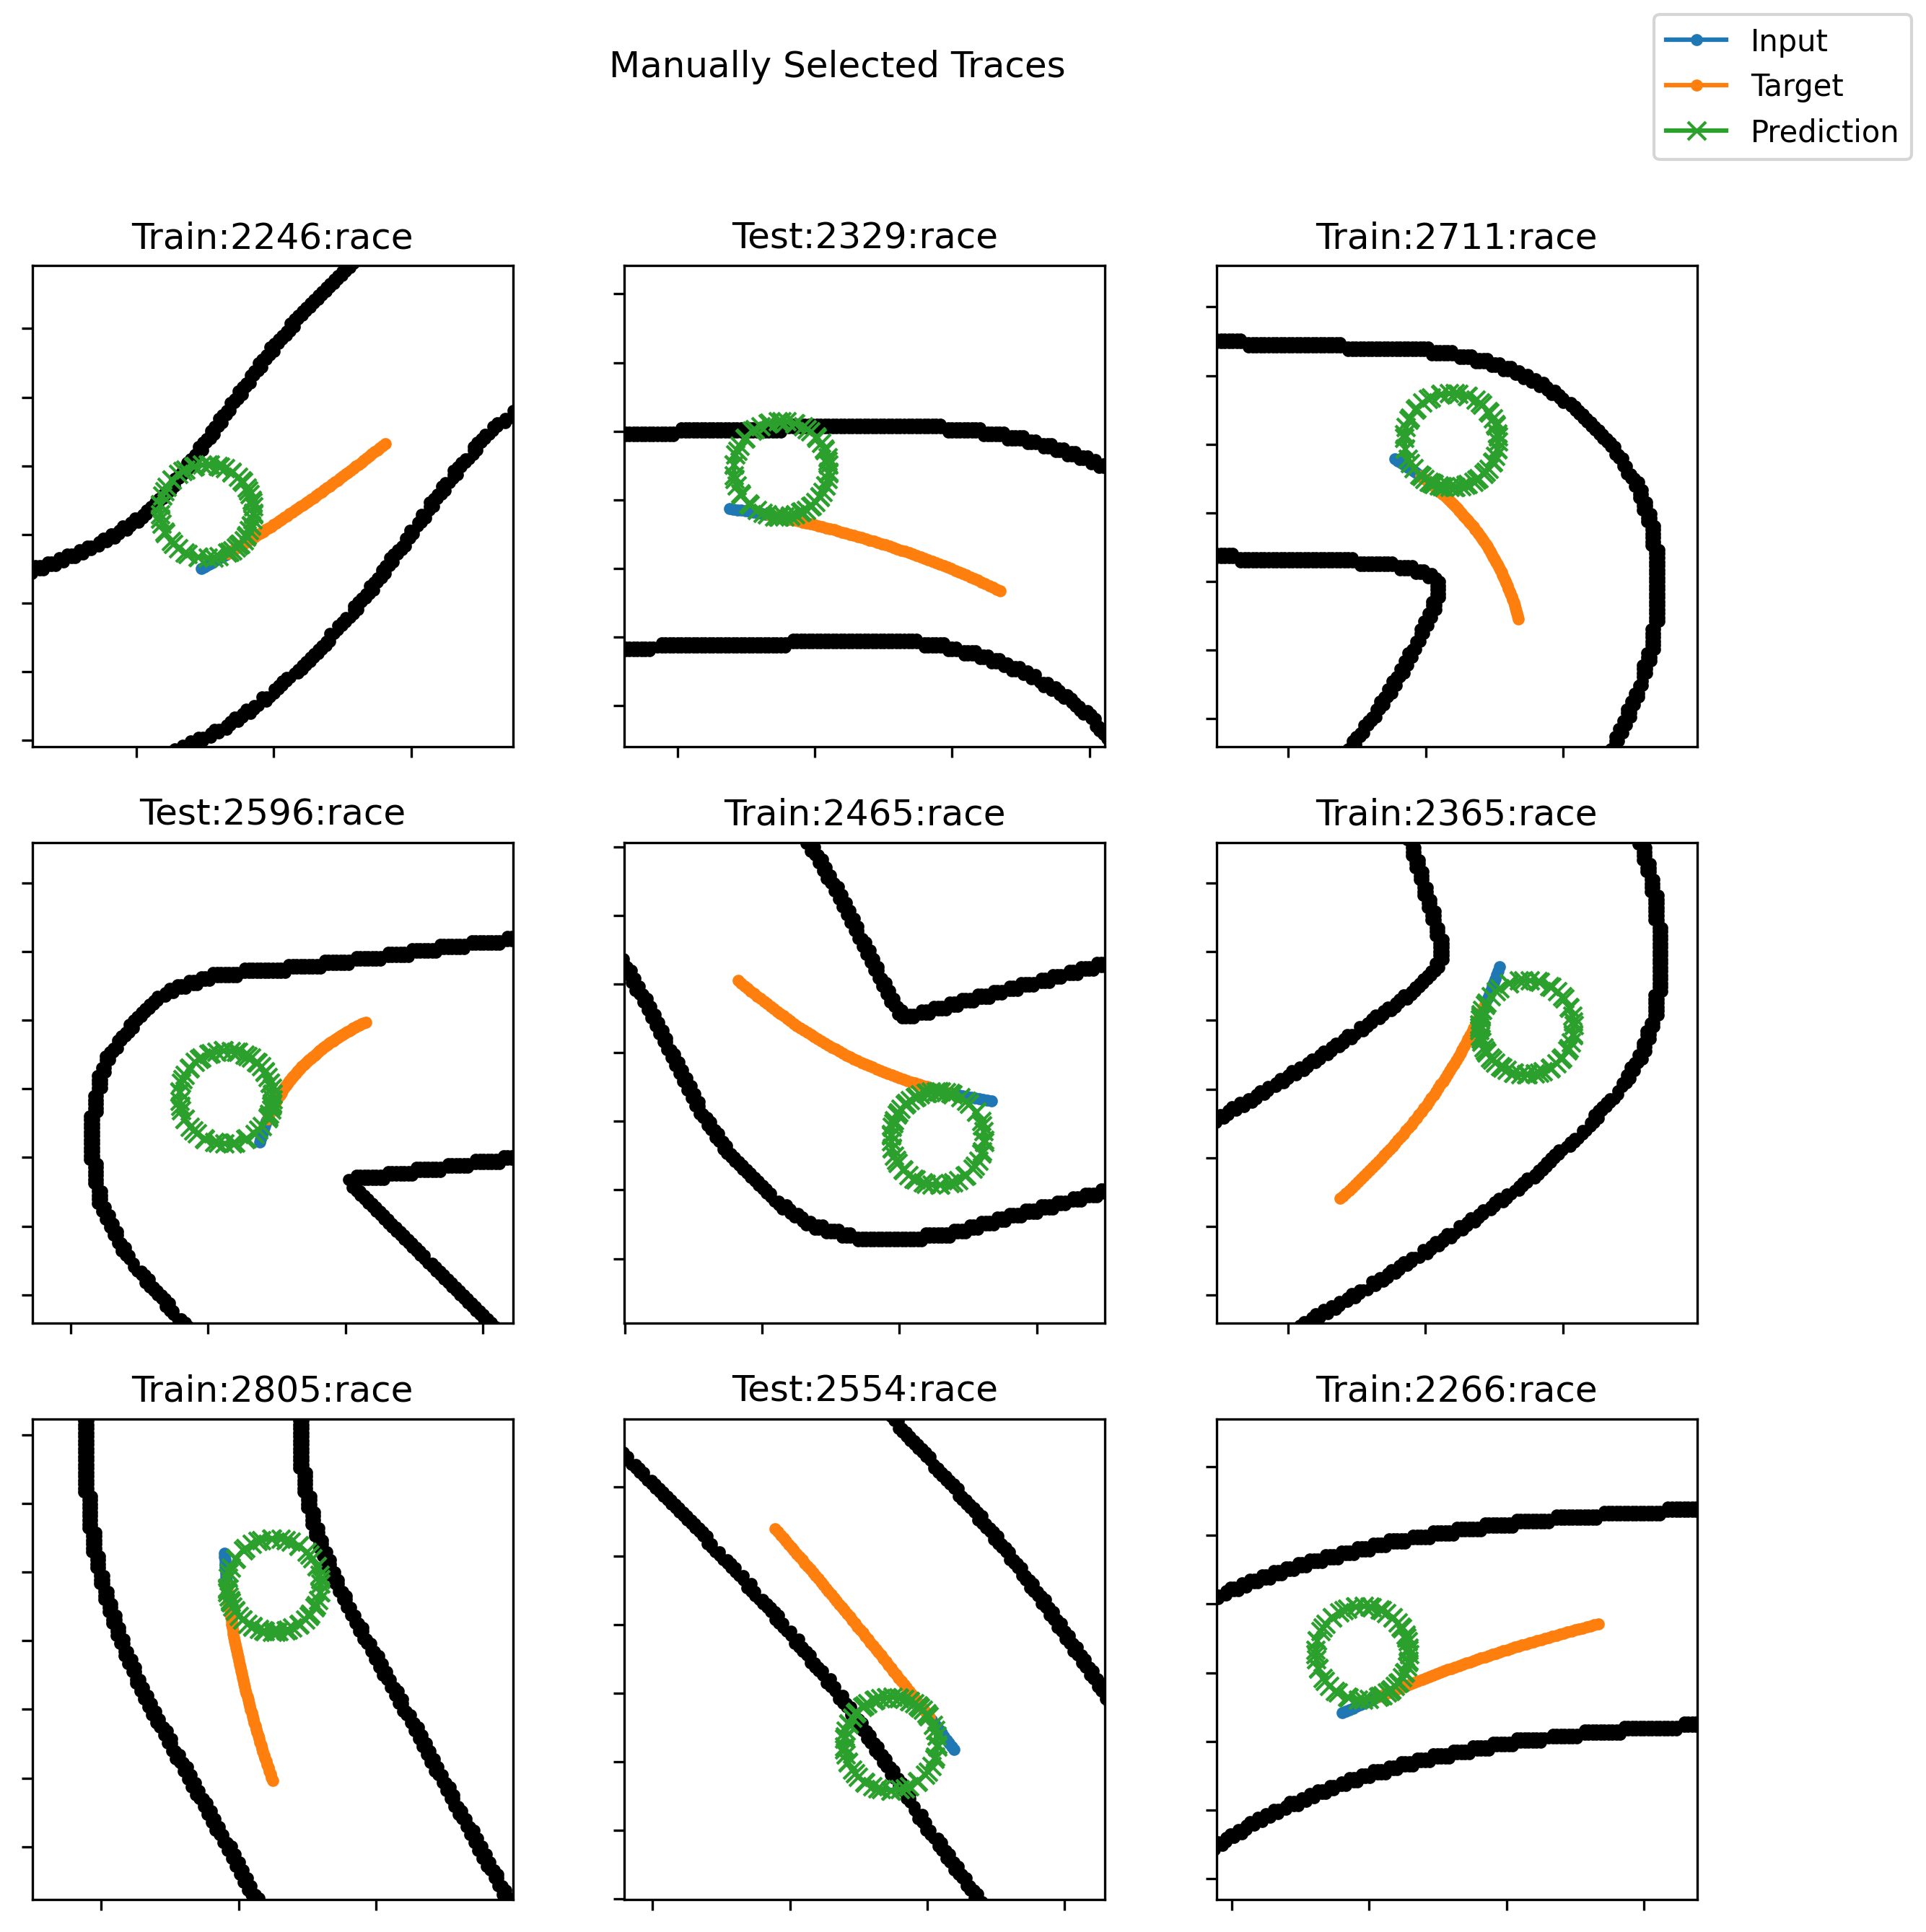

In [50]:
selection = [2246, 2329, 2711, 2596, 2465, 2365, 2805, 2554, 2266]
create_debug_plot(net, selection=selection)